In [1]:
# This demo code is inspired by https://github.com/facebookresearch/ToMe/blob/main/examples/0_validation_timm.ipynb.
from torchvision import transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import ast
import sys

def print_topk_predictions(model, img_tensor, topk=5, device="cuda"):
    model.to(device)
    img_tensor = img_tensor.to(device)
    
    with open('imagenet1000clsidx_to_list.txt', 'r') as file:
        idx2cls_txt = file.read()
    
    idx2cls = ast.literal_eval(idx2cls_txt)
    logits = model(img_tensor)
    probabilities = F.softmax(logits, dim=1)
    topk_result = probabilities.topk(topk)
    topk_indices = topk_result.indices[0].tolist()
    topk_probs = topk_result.values[0].tolist()
    
    for rank, (idx, prob) in enumerate(zip(topk_indices, topk_probs)):
        print(f"Top {rank+1} class | idx: {idx} | name: {idx2cls[idx]} | probability: {prob:.4f}")

In [2]:
# pre-trained weights
!gdown -O ckpt/mobilenetv2_100_ra-b33bc2c4.pth 1r_ToZhZP7cz6DZh4f3r1VWf0fpdGL0XX

# compressed weights
!gdown -O ckpt/mbv2_tl13.4_checkpoint_ft_lr0.05.pth 1K3ZS8CztsEK7-mSckYLd6PrSlCVImmDb 

Downloading...
From: https://drive.google.com/uc?id=1r_ToZhZP7cz6DZh4f3r1VWf0fpdGL0XX
To: /data_fast/home/jusjinuk/codes/LayerMerge/examples/ckpt/mobilenetv2_100_ra-b33bc2c4.pth
100%|██████████████████████████████████████| 14.3M/14.3M [00:04<00:00, 3.53MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1K3ZS8CztsEK7-mSckYLd6PrSlCVImmDb
From (redirected): https://drive.google.com/uc?id=1K3ZS8CztsEK7-mSckYLd6PrSlCVImmDb&confirm=t&uuid=5a4c1950-4fc5-4d2e-961c-324d05971100
To: /data_fast/home/jusjinuk/codes/LayerMerge/examples/ckpt/mbv2_tl13.4_checkpoint_ft_lr0.05.pth
100%|██████████████████████████████████████| 28.2M/28.2M [00:02<00:00, 10.1MB/s]


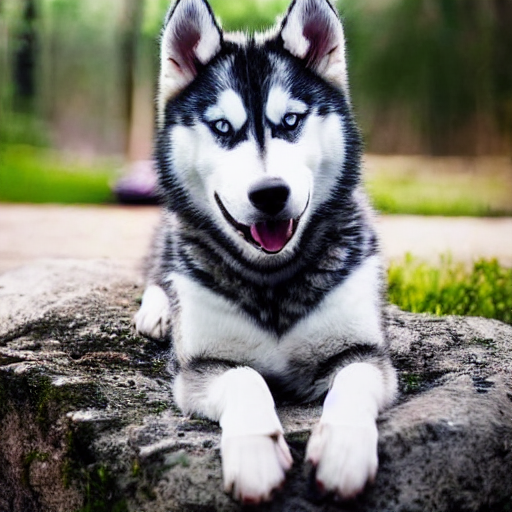

In [3]:
input_size = 224
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Image generated by stable diffusion
img = Image.open("images/husky.png")
img_tensor = transform(img)[None, ...]

img

In [4]:
# pretrained MobileNetV2-1.0 from Efficient-CNN-Depth-Compression
sys.path.append('../Efficient-CNN-Depth-Compression')
from models.imagenet import MobileNetV2


state = torch.load("ckpt/mobilenetv2_100_ra-b33bc2c4.pth")
pretrained_model = MobileNetV2()
pretrained_model.eval()
pretrained_model = nn.DataParallel(pretrained_model)
pretrained_model.load_state_dict(state['state_dict'])
pretrained_model

TensorRT is not installed


DataParallel(
  (module): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU6(inplace=True)
          (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(96, eps=1e-0

In [5]:
# Fuse batchnorm layers
pretrained_model.module.merge()
pretrained_model = pretrained_model.module
pretrained_model

Fused batchnorm...


MobileNetV2(
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )
  (m_features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): ReLU6(inplace=True)
    )
    (1): NaiveFeed(
      (md): Sequential(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (relu1): ReLU6(inplace=True)
        (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): NaiveFeed(
      (md): Sequential(
        (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
        (relu1): ReLU6(inplace=True)
        (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96)
        (relu2): ReLU6(inplace=True)
        (conv3): Conv2d(96, 24, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (3): SkipFeed(
      (md): Sequential(
        (conv1): Conv

In [6]:
# Top-5 prediction of previous image with pre-trained network
print_topk_predictions(pretrained_model, img_tensor)

Top 1 class | idx: 248 | name: Eskimo dog, husky | probability: 0.5287
Top 2 class | idx: 250 | name: Siberian husky | probability: 0.3235
Top 3 class | idx: 249 | name: malamute, malemute, Alaskan malamute | probability: 0.1283
Top 4 class | idx: 537 | name: dogsled, dog sled, dog sleigh | probability: 0.0026
Top 5 class | idx: 174 | name: Norwegian elkhound, elkhound | probability: 0.0012


In [7]:
from layer_merge.models.mobilenetv2_merged_layer import DepthLayerMobileNetV2, make_depth_layer_mobilenet_v2

# Network compressed with T_0 = 13.4
act_pos = [0, 5, 8, 11, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
conv_pos = [0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
state = torch.load("ckpt/mbv2_tl13.4_checkpoint_ft_lr0.05.pth")


pruned_model = make_depth_layer_mobilenet_v2(set(act_pos), set(conv_pos))
pruned_model.eval()
pruned_model = nn.DataParallel(pruned_model)
# Load the weights
pruned_model.load_state_dict(state["state_dict"])
# Fine-tuned model
pruned_model

DataParallel(
  (module): DepthLayerMobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): DepthInvertedResidual(
        (conv): Sequential(
          (conv1): Identity()
          (bn1): Identity()
          (relu1): Identity()
          (conv2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): Identity()
        )
      )
      (2): DepthInvertedResidual(
        (conv): Sequential(
          (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): Identity()
    

In [8]:
# Merged model
compressed_model = pruned_model.module.merge()
compressed_model

Sequential(
  (blk0): NaiveFeed(
    (md): Sequential(
      (merged_conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu0): ReLU6(inplace=True)
      (merged_conv5): Conv2d(32, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu5): ReLU6(inplace=True)
      (merged_conv8): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
      (relu8): ReLU6(inplace=True)
      (merged_conv11): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (relu11): ReLU6(inplace=True)
      (merged_conv14): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu14): ReLU6(inplace=True)
      (merged_conv17): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu17): ReLU6(inplace=True)
      (merged_conv18): Conv2d(32, 192, kernel_size=(1, 1), stride=(1, 1))
      (relu18): ReLU6(inplace=True)
      (merged_conv19): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=192)
      (relu19): ReLU6

In [9]:
# Predictions stay consistent after compression
print_topk_predictions(compressed_model, img_tensor)

Top 1 class | idx: 248 | name: Eskimo dog, husky | probability: 0.5620
Top 2 class | idx: 250 | name: Siberian husky | probability: 0.3250
Top 3 class | idx: 249 | name: malamute, malemute, Alaskan malamute | probability: 0.1128
Top 4 class | idx: 174 | name: Norwegian elkhound, elkhound | probability: 0.0001
Top 5 class | idx: 269 | name: timber wolf, grey wolf, gray wolf, Canis lupus | probability: 0.0000


In [10]:
sys.path.append('../Efficient-CNN-Depth-Compression')
from utils.measure import torch_time, compile_and_time

pretrained_model.to('cuda')
pretrained_time, pretrained_std = torch_time(pretrained_model, (128, 3, 224, 224), "pretrained", True)

Measuring time without TensorRT compiling...
Batch size is 128
Measure time 12.14 seconds
[          pretrained] THPT : 3217.21 || STD : 3.36
[          pretrained] MEAN : 39.79ms || STD : 0.04


In [11]:
compressed_model.to('cuda')
compressed_time, compressed_std = torch_time(compressed_model, (128, 3, 224, 224), "pretrained", True)

Measuring time without TensorRT compiling...
Batch size is 128
Measure time 4.99 seconds
[          pretrained] THPT : 8035.17 || STD : 19.06
[          pretrained] MEAN : 15.93ms || STD : 0.04


In [12]:
# Calculate the speedup
speedup = (pretrained_time / compressed_time)

# Print the speedup
print(f"Inference Speedup: {speedup:.2f}x")

Inference Speedup: 2.50x
